In [1]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds, FalsePositiveRateParity, TruePositiveRateParity
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate_difference, false_positive_rate_difference, equalized_odds_difference

In [93]:
df_train = pd.read_csv('../DataSets/compas_train_1.csv')
df_test = pd.read_csv('../DataSets/compas_test_1.csv')
# df_train_cal = pd.read_csv('../DataSets/kamiran_compas_train_calibration_1.csv')

In [94]:
df_train['target'] -= 1
df_test['target'] -= 1

In [95]:
X_cols = ['race', 'age_cat', 'sex', 'priors_count', 'c_charge_degree', 'length_of_stay']
y_col = 'target'
l_col = 'race'

race_train = df_train[l_col]
X_train = df_train[X_cols]
y_train = df_train[y_col]

race_test = df_test[l_col]
X_test = df_test[X_cols]
y_test = df_test[y_col]

In [65]:
def corr_remover(classifier, metric, X_cols, y_col, l_col, df_train, df_test, alpha, seed):
    l_train = df_train[l_col]
    X_train = df_train[X_cols]
    y_train = df_train[y_col]

    l_test = df_test[l_col]
    X_test = df_test[X_cols]
    y_test = df_test[y_col]
    
    np.random.seed(seed)
    
    c = CorrelationRemover(sensitive_feature_ids=[l_col], alpha=alpha)
    c.fit(X_train, y_train)
    X_train_trans = pd.DataFrame(c.transform(X_train), columns=X_cols[1:])
    X_test_trans = pd.DataFrame(c.transform(X_test), columns=X_cols[1:])
    
    classifier.fit(X_train_trans, y_train)
    y_test_pred = classifier.predict(X_test_trans)
    
    return accuracy_score(y_test, y_test_pred), metric(y_true=y_test, y_pred=y_test_pred, sensitive_features=l_test)

#     sr_mitigated = MetricFrame(metrics=metric, y_true=y_test, y_pred=y_test_pred, sensitive_features=race_test)
    
#     dic = sr_mitigated.by_group.to_dict()
#     print(max(dic.values()) - min(dic.values()))

In [66]:
def run_exp_gradient(classifier, constraint, metric, X_cols, y_col, l_col, df_train, df_test, eps, seed):
    l_train = df_train[l_col]
    X_train = df_train[X_cols]
    y_train = df_train[y_col]

    l_test = df_test[l_col]
    X_test = df_test[X_cols]
    y_test = df_test[y_col]
    
    np.random.seed(seed)
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    mitigator = ExponentiatedGradient(classifier, constraint, eps=eps)
    mitigator.fit(X_train, y_train, sensitive_features=l_train)
    
    y_pred_mitigated = mitigator.predict(X_test)
    
    return accuracy_score(y_test, y_pred_mitigated), metric(y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=l_test)
    
#     sr_mitigated = MetricFrame(metrics=metric, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=l_test)
    
#     dic = sr_mitigated.by_group.to_dict()
#     print(max(dic.values()) - min(dic.values()))

In [67]:
def run_threshold(classifier, constraint, metric, prefit, X_cols, y_col, l_col, df_train, df_test, seed):
    l_train = df_train[l_col]
    X_train = df_train[X_cols]
    y_train = df_train[y_col]

    l_test = df_test[l_col]
    X_test = df_test[X_cols]
    y_test = df_test[y_col]
    
    np.random.seed(seed)
    
    classifier.fit(X_train, y_train)
    postprocess_est = ThresholdOptimizer(
                   estimator=classifier,
                   constraints=constraint,
                   objective="accuracy_score",
                   prefit=prefit,
                   predict_method='predict')
    postprocess_est.fit(X_train, y_train, sensitive_features=l_train)
    
    y_pred_mitigated = postprocess_est.predict(X_test, sensitive_features=l_test)
    
    return accuracy_score(y_test, y_pred_mitigated), metric(y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=l_test)
    
#     sr_mitigated = MetricFrame(metrics=metric, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=l_test)
    
#     dic = sr_mitigated.by_group.to_dict()
#     print(dic)
#     print(max(dic.values()) - min(dic.values()))

In [ ]:
dataset = 'compas'
splits = [1, 2, 3, 4, 5]
X_cols = ['race', 'age_cat', 'sex', 'priors_count', 'c_charge_degree', 'length_of_stay']
y_col = 'target'
l_col = 'race'

In [ ]:
df_train = pd.read_csv(f'../DataSets/{dataset}_train_{split}.csv')
df_test = pd.read_csv(f'../DataSets/{dataset}_test_{split}.csv')
df_train['target'] -= 1
df_test['target'] -= 1

race_train = df_train[l_col]
X_train = df_train[X_cols]
y_train = df_train[y_col]

race_test = df_test[l_col]
X_test = df_test[X_cols]
y_test = df_test[y_col]

Outline of experiments
- data: [compas, adult, german]
- splits: [1, 2, 3, 4, 5]
- methods: correlation remover, threshold, exponentiated gradient
    - correlation remover: alpha from [0, 1], 5 seeds (don't know if seeds is necessary)
    - threshold: no tuning, 5 seeds
    - exp_gradient: eps from [0.01, 0.5], 5 seeds
- classifiers: Random Forest, Decision Tree, Logistic Regression, SVM, MLP
- metrics: DP, FPR, TPR, EO
    - DP: selection_rate
    - FPR: false_positive_rate
    - TPR: true_positive_rate
    - EO: equalized_odds_difference -- kind of, there's no way of getting the disparity of this...

run once to protoype

In [44]:
dataset = 'german_binary'
split = 1
X_cols = ['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'native_country', 'fnlwgt',
       'hours_per_week', 'capital', 'age_group']

y_col = 'target'
l_col = 'sex'

In [45]:
df_train = pd.read_csv(f'../DataSets/{dataset}_train_{split}.csv')
df_test = pd.read_csv(f'../DataSets/{dataset}_test_{split}.csv')

In [7]:
df_train['target'] -= 1
df_test['target'] -= 1

race_train = df_train[l_col]
X_train = df_train[X_cols]
y_train = df_train[y_col]

race_test = df_test[l_col]
X_test = df_test[X_cols]
y_test = df_test[y_col]

In [18]:
alpha = 0.5
seed = 1

In [19]:
acc, disp = corr_remover(LogisticRegression(), demographic_parity_difference, 
                         X_cols, y_col, l_col, df_train, df_test, alpha, seed)

In [20]:
acc, disp

(0.7601113910621934, 0.12847917370452008)

In [68]:
dataset = 'german_binary' # 'compas', 'german_binary'
splits = [1, 2, 3, 4, 5]

In [69]:
if dataset == 'compas':
    X_cols = ['race', 'age_cat', 'sex', 'priors_count', 'c_charge_degree', 'length_of_stay']
    y_col = 'target'
    l_col = 'race'
elif dataset == 'adult':
    X_cols = ['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'native_country', 'fnlwgt', 'sex',
       'hours_per_week', 'capital', 'age_group']
    y_col = 'target'
    l_col = 'sex'
elif dataset == 'german_binary':
    X_cols = ['chek_acc', 'month_duration', 'credit_history', 'purpose',
       'Credit_amo', 'saving_amo', 'present_employmment', 'instalrate',
       'p_status', 'guatan', 'present_resident', 'property', 'age',
       'installment', 'Housing', 'existing_cards', 'job', 'no_people',
       'telephn', 'foreign_worker']
    y_col = 'target'
    l_col = 'age'

In [70]:
classifiers = {'RF': RandomForestClassifier(), 'LR': LogisticRegression(), 'DT': DecisionTreeClassifier(),
              'SVM': SVC(), 'MLP': MLPClassifier(), 'KNN': KNeighborsClassifier()}
metrics = {'DP': demographic_parity_difference, 'TPR': true_positive_rate_difference,
          'FPR': false_positive_rate_difference, 'EO': equalized_odds_difference}

In [71]:
df = pd.DataFrame(columns=['dataset', 'split', 'method', 'seed', 'classifier', 'metric', 'acc', 'disp', 'hyp'])

In [72]:
# run correlation remover
alphas = np.linspace(0, 1, 10)
seeds = [1, 100, 9, 50, 1111]
for split in tqdm(splits, desc=' splits', position=0):
    df_train = pd.read_csv(f'../DataSets/{dataset}_train_{split}.csv')
    df_test = pd.read_csv(f'../DataSets/{dataset}_test_{split}.csv')
    df_train['target'] -= 1
    df_test['target'] -= 1
    for seed in tqdm(seeds, desc=' seeds', position=1, leave=False):
        for cl, classifier in classifiers.items():
            for met, metric in metrics.items():
                for alpha in alphas:
                    acc, disp = corr_remover(classifier, metric, X_cols, y_col, l_col, df_train, df_test, alpha, seed)
                    df.loc[len(df)] = [dataset, split, 'correlation_remover', seed, cl, met, acc, disp, alpha]

 splits: 100%|██████████| 5/5 [39:25<00:00, 473.10s/it]A


In [98]:
df.to_csv(f'{dataset}_results.csv', index=False)

In [73]:
metrics_constraints = {'DP': [demographic_parity_difference, 'demographic_parity'], 
                      'TPR': [true_positive_rate_difference, 'true_positive_rate_parity'],
                      'FPR': [false_positive_rate_difference, 'false_positive_rate_parity'], 
                      'EO': [equalized_odds_difference, 'equalized_odds']}

# run threshold optimizer
seeds = [1, 100, 9, 50, 1111]
for split in tqdm(splits, desc=' splits', position=0):
# for split in splits:
    df_train = pd.read_csv(f'../DataSets/{dataset}_train_{split}.csv')
    df_test = pd.read_csv(f'../DataSets/{dataset}_test_{split}.csv')
    df_train['target'] -= 1
    df_test['target'] -= 1
    for seed in tqdm(seeds, desc=' seeds', position=1, leave=False):
        for cl, classifier in classifiers.items():
            for met, metric in metrics_constraints.items():
                for prefit, suffix in zip([True, False], ['prefit', 'no_prefit']):
                    acc, disp = run_threshold(classifier, metric[1], metric[0], prefit, X_cols, y_col, l_col, df_train, df_test, seed)
                    df.loc[len(df)] = [dataset, split, f'threshold_optimizer', seed, cl, met, acc, disp, suffix]

In [92]:
df = pd.read_csv(f'{dataset}_results.csv')

In [93]:
df = df[(df['method'] != 'exp_gradient') | (df['split'] != 2)].reset_index(drop=True)

In [97]:
df[df['method'] == 'exp_gradient']['split'].value_counts()

1    640
2    159
Name: split, dtype: int64

In [96]:
df

,dataset,split,method,seed,classifier,metric,acc,disp,hyp
0,compas,1,correlation_remover,1,RF,DP,0.680493,0.308451,0.0
1,compas,1,correlation_remover,1,RF,DP,0.654569,0.245440,0.1111111111111111
2,compas,1,correlation_remover,1,RF,DP,0.652625,0.245440,0.2222222222222222
3,compas,1,correlation_remover,1,RF,DP,0.654569,0.245440,0.3333333333333333
4,compas,1,correlation_remover,1,RF,DP,0.654569,0.245440,0.4444444444444444
...,...,...,...,...,...,...,...,...,...
7994,compas,2,exp_gradient,100,SVM,EO,0.657809,0.119773,0.045
7995,compas,2,exp_gradient,100,SVM,EO,0.657809,0.119773,0.056
7996,compas,2,exp_gradient,100,SVM,EO,0.657809,0.119773,0.067
7997,compas,2,exp_gradient,100,SVM,EO,0.657809,0.119773,0.078


In [ ]:
metrics_constraints = {'DP': [demographic_parity_difference, DemographicParity()], 
                      'TPR': [true_positive_rate_difference, TruePositiveRateParity()],
                      'FPR': [false_positive_rate_difference, FalsePositiveRateParity()], 
                      'EO': [equalized_odds_difference, EqualizedOdds()]}

classifiers = {'RF': RandomForestClassifier(), 'LR': LogisticRegression(), 'DT': DecisionTreeClassifier(),}
#               'SVM': SVC()}

# run exponentiated gradient
seeds = [100, 9, 50, 1111]
epsilons = np.linspace(0.001, 0.1, 10)
for split in tqdm(splits[2:], desc=' splits', position=0):
    df_train = pd.read_csv(f'../DataSets/{dataset}_train_{split}.csv')
    df_test = pd.read_csv(f'../DataSets/{dataset}_test_{split}.csv')
    df_train['target'] -= 1
    df_test['target'] -= 1
    for seed in tqdm(seeds, desc=' seeds', position=1, leave=False):
        for cl, classifier in tqdm(classifiers.items(), desc=' classifiers', position=2, leave=False):
            for met, metric in metrics_constraints.items():
                for eps in epsilons:
                    if met == 'DP':
                        constraint = DemographicParity()
                    elif met == 'TPR':
                        constraint = TruePositiveRateParity()
                    elif met == 'FPR':
                        constraint = FalsePositiveRateParity()
                    elif met == 'EO':
                        constraint = EqualizedOdds()
                    
                    acc, disp = run_exp_gradient(classifier, constraint, metric[0], X_cols, y_col, l_col, df_train, df_test, eps, seed)
                    df.loc[len(df)] = [dataset, split, 'exp_gradient', seed, cl, met, acc, disp, eps]

 seeds:   0%|          | 0/4 [00:00<?, ?it/s]

 classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

 classifiers:  33%|███▎      | 1/3 [07:41<15:22, 461.37s/it]

 classifiers:  67%|██████▋   | 2/3 [09:33<04:15, 255.79s/it]

 classifiers: 100%|██████████| 3/3 [11:34<00:00, 194.45s/it]

                                                            
 seeds:  25%|██▌       | 1/4 [11:34<34:44, 694.71s/it]

 classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

 classifiers:  33%|███▎      | 1/3 [06:46<13:33, 406.84s/it]

 classifiers:  67%|██████▋   | 2/3 [08:41<03:54, 234.71s/it]

 classifiers: 100%|██████████| 3/3 [10:46<00:00, 185.01s/it]

                                                            
 seeds:  50%|█████     | 2/4 [22:21<22:13, 666.60s/it]

 classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

 classifiers:  33%|███▎      | 1/3 [07:12<14:24, 432.39s/it]

 classifiers:  67%|██████▋   | 2/3 [09:05<04:04, 244.32s/it]

 classifiers: 100%|██████████| 3/3 [11:08<00:00, 189.02s/it]

  

In [89]:
constraint = DemographicParity()
classifier = RandomForestClassifier()
run_threshold(classifier, constraint, selection_rate, X_cols, y_col, l_col, df_train, df_test, 10)

{1: 0.3522012578616352, 2: 0.37714285714285717, 3: 0.2755905511811024, 4: 0.3333333333333333}
0.1015523059617548


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv('compas_results.csv')

In [35]:
header = pd.read_csv('../header.csv')

In [36]:
flowoct = pd.read_csv('../Results/Facct 2022 Final/Flow (Dec 29)/FlowOCT/FlowOCT_compas.csv', 
                      header=None, names=list(header.columns))

In [37]:
def consolidate(row):
    if row['fair type'] == 'EOdds':
        return row['EOdds test pred']
    elif row['fair type'] == 'SP':
        return row['sp test pred']
    elif row['fair type'] == 'CSP':
        return row['csp test pred']
    elif row['fair type'] == 'EOpp':
        return row['EOpp test pred']
    elif row['fair type'] == 'PE':
        return row['pe test pred']

In [38]:
flowoct['test_disp'] = flowoct.apply(lambda row: consolidate(row), axis=1)

In [39]:
flowoct = flowoct[flowoct['fair type'] != 'None']

In [40]:
flowoct_avg = flowoct[['fair type', 
         'fair bound', 
         'test acc', 
         'test_disp']].groupby(['fair type', 'fair bound']).agg('mean').reset_index()

In [41]:
flowoct_avg = flowoct_avg.rename(columns={'fair bound': 'hyp', 'test acc': 'acc', 'test_disp': 'disp'})

In [42]:
flowoct_avg['method'] = 'FairOCT'

In [43]:
flowoct_avg

,fair type,hyp,acc,disp,method
0,CSP,0.01,0.649384,0.000000,FairOCT
1,CSP,0.02,0.649384,0.000000,FairOCT
2,CSP,0.03,0.649384,0.000000,FairOCT
3,CSP,0.04,0.647699,0.008335,FairOCT
4,CSP,0.05,0.648218,0.028924,FairOCT
...,...,...,...,...,...
270,SP,0.51,0.669086,0.304002,FairOCT
271,SP,0.52,0.669086,0.304002,FairOCT
272,SP,0.53,0.669086,0.304002,FairOCT
273,SP,0.54,0.669086,0.304002,FairOCT


In [26]:
xwalk = {'DP': 'SP', 'EO': 'EOpp', 'TPR': 'EOdds', 'FPR': 'PE'}
classifier_xwalk = {'FairOCT': 0, 'DT': 1, 'KNN': 4, 'LR': 2, 'MLP': 6, 'RF': 5, 'SVM': 3}
reverse_xwalk = {j: i for i, j in classifier_xwalk.items()}

In [27]:
cmap = sns.color_palette("rocket", as_cmap=True)

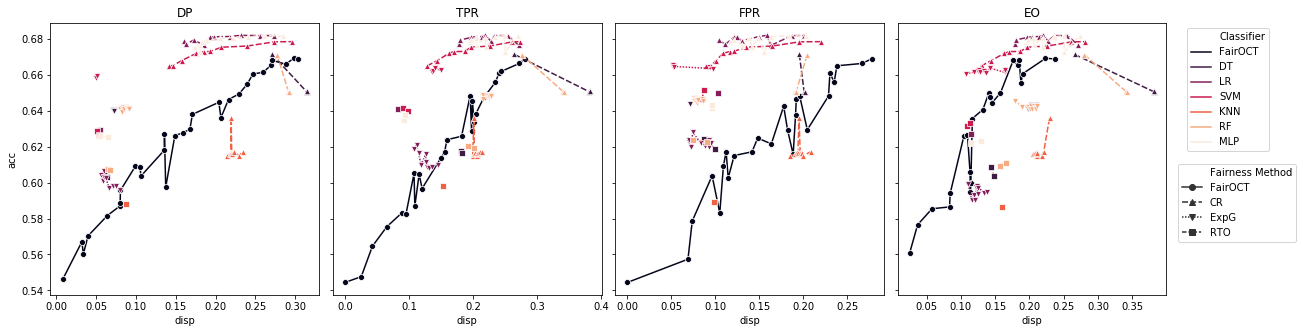

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, a in zip(df['metric'].unique(), [ax1, ax2, ax3, ax4]):
    subset = df[df['metric'] == i]
    subset_oct = flowoct_avg[flowoct_avg['fair type'] == xwalk[i]].drop(columns=['fair type'])
    subset_oct['classifier'] = 'FairOCT'
    subset = pd.concat([subset, subset_oct], ignore_index=True)
    subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
    subset = subset[['acc', 'disp', 'classifier_num', 'method', 'hyp']].groupby(['classifier_num', 'method', 'hyp']).agg('mean').reset_index()
    sns.lineplot(data=subset, x='disp', y='acc', hue='classifier_num', style='method', ax=a, markers=["o", "^", "v", "s"], palette=cmap)
#     sns.lineplot(data=subset_oct, x='disp', y='acc', ax=a, marker='s')
    if i == 'EO':
        h,l = a.get_legend_handles_labels()
        l1 = a.legend(h[:8],['Classifier']+[reverse_xwalk[i] for i in range(7)], bbox_to_anchor=(1.4, 1.0))
        l2 = a.legend(h[8:],['Fairness Method']+['FairOCT', 'CR', 'ExpG', 'RTO'], bbox_to_anchor=(1.5, 0.5))
        a.add_artist(l1)
#         a.legend(bbox_to_anchor=(1.5, 0.5))
    else:
        leg = a.get_legend()
        leg.remove()
    a.set_title(i)
plt.subplots_adjust(wspace=0.05)
plt.savefig('compas.pdf', bbox_inches='tight')
plt.show()

In [33]:
df[df['method'] == 'exp_gradient']

,dataset,split,method,seed,classifier,metric,acc,disp,hyp,time
7200,german_binary,3,exp_gradient,1,RF,DP,0.768,0.060668,0.001,15.954641
7201,german_binary,3,exp_gradient,1,RF,DP,0.768,0.060668,0.012,15.989295
7202,german_binary,3,exp_gradient,1,RF,DP,0.768,0.060668,0.023000000000000003,15.953065
7203,german_binary,3,exp_gradient,1,RF,DP,0.768,0.060668,0.034,16.109374
7204,german_binary,3,exp_gradient,1,RF,DP,0.768,0.060668,0.045000000000000005,15.985457
...,...,...,...,...,...,...,...,...,...,...
7675,german_binary,5,exp_gradient,1,SVM,EO,0.788,0.089166,0.05600000000000001,2.838359
7676,german_binary,5,exp_gradient,1,SVM,EO,0.800,0.149425,0.067,3.138248
7677,german_binary,5,exp_gradient,1,SVM,EO,0.780,0.052874,0.07800000000000001,2.884203
7678,german_binary,5,exp_gradient,1,SVM,EO,0.800,0.149425,0.08900000000000001,3.152141


<ipython-input-16-e25e92e7ccbe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
<ipython-input-16-e25e92e7ccbe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
<ipython-input-16-e25e92e7ccbe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

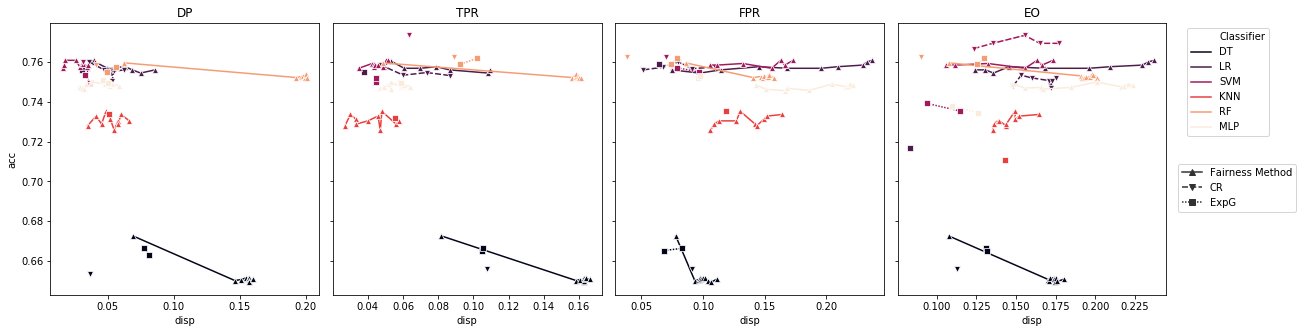

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, a in zip(df['metric'].unique(), [ax1, ax2, ax3, ax4]):
    subset = df[df['metric'] == i]
#     subset_oct = flowoct_avg[flowoct_avg['fair type'] == xwalk[i]].drop(columns=['fair type'])
#     subset_oct['classifier'] = 'FairOCT'
#     subset = pd.concat([subset, subset_oct], ignore_index=True)
    subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
    subset = subset[['acc', 'disp', 'classifier_num', 'method', 'hyp']].groupby(['classifier_num', 'method', 'hyp']).agg('mean').reset_index()
    sns.lineplot(data=subset, x='disp', y='acc', hue='classifier_num', style='method', ax=a, markers=["^", "v", "s"], palette=cmap)
#     sns.lineplot(data=subset_oct, x='disp', y='acc', ax=a, marker='s')
    if i == 'EO':
        h,l = a.get_legend_handles_labels()
        l1 = a.legend(h[:8],['Classifier']+[reverse_xwalk[i] for i in range(1, 7)], bbox_to_anchor=(1.4, 1.0))
        l2 = a.legend(h[8:],['Fairness Method']+['CR', 'ExpG', 'RTO'], bbox_to_anchor=(1.5, 0.5))
        a.add_artist(l1)
#         a.legend(bbox_to_anchor=(1.5, 0.5))
    else:
        leg = a.get_legend()
        leg.remove()
    a.set_title(i)
plt.subplots_adjust(wspace=0.05)
plt.savefig('german.pdf', bbox_inches='tight')
plt.show()

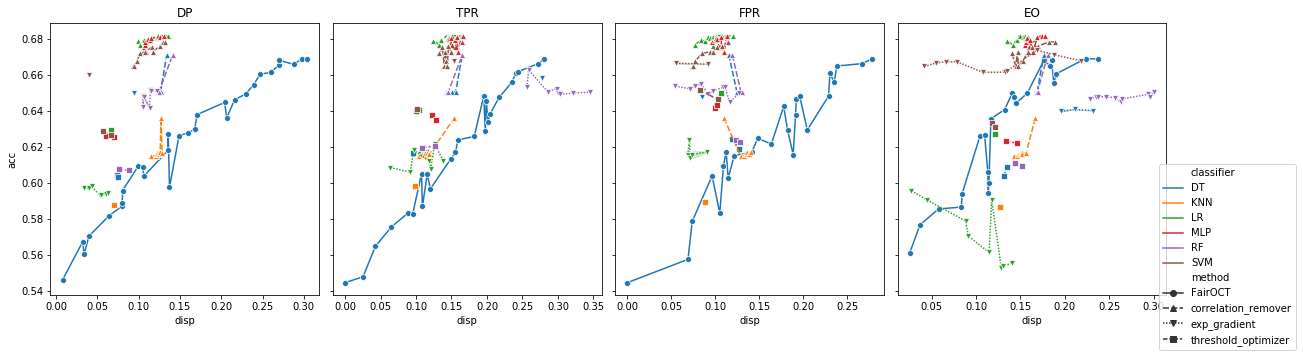

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, a in zip(df['metric'].unique(), [ax1, ax2, ax3, ax4]):
    subset = df[df['metric'] == i]
    subset_oct = flowoct_avg[flowoct_avg['fair type'] == xwalk[i]].drop(columns=['fair type'])
    subset_oct['classifier'] = 'DT'
    subset = pd.concat([subset, subset_oct], ignore_index=True)
    subset = subset[['acc', 'disp', 'classifier', 'method', 'hyp']].groupby(['classifier', 'method', 'hyp']).agg('mean').reset_index()
    sns.lineplot(data=subset, x='disp', y='acc', hue='classifier', style='method', ax=a, markers=["o", "^", "v", "s"])
#     sns.lineplot(data=subset_oct, x='disp', y='acc', ax=a, marker='s')
    if i == 'EO':
        h,l = a.get_legend_handles_labels()
        l1 = a.legend(h[:8],['Classifier']+[reverse_xwalk[i] for i in range(7)], bbox_to_anchor=(1.4, 1.0))
        l2 = a.legend(h[8:],['Fairness Method']+['FairOCT', 'CR', 'ExpG', 'RTO'], bbox_to_anchor=(1.5, 0.5))
        a.add_artist(l1)
#         a.legend(bbox_to_anchor=(1.5, 0.5))
    else:
        leg = a.get_legend()
        leg.remove()
    a.set_title(i)
plt.subplots_adjust(wspace=0.05)
# plt.savefig('prelim_results_compas_test.pdf', bbox_inches='tight')
plt.show()

In [187]:
df.to_csv('results.csv', index=False)